# Visualizing the log data:

#### Importing packages

In [1]:
from glob import glob
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import tuner
from polyphys.visualize import plotter
from polyphys.manage.parser import SumRuleCyl, TransFociCyl

### Importing datasets

In [39]:
database = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/'
project = 'SumRuleCyl'
df_path = database + project + "-allInOne-"
#thermo = pd.read_parquet(df_path + "thermo.parquet.brotli")
run_stat = pd.read_csv(df_path + "runStat.csv")
wall_time = pd.read_csv(df_path + "wallTimeStat.csv")

## Visualizing the run stats: 

In [40]:
# droping prblematic (broken, restarted, faked) run stats and keep complete
# ones:
run_stat_comp = run_stat[run_stat.lineage_name.str.contains('ens[1-8]$|j0[12]$')]
run_stat_comp.reset_index(inplace=True,drop=True)
# keep data from the production phase in whic the loop_timesteps is equal to
# 5000000 ro larger than that:
run_stat_prod = run_stat_comp[run_stat_comp.loop_timesteps >= 5000000]


In [71]:
sel_cols = ['Pair_total_pct', 'Bond_total_pct', 'Neigh_total_pct',
            'Comm_total_pct', 'Output_total_pct', 'Modify_total_pct',
            'Other_total_pct']
agg_funcs = {key: np.mean for key in sel_cols}
run_stats_per_cor_per_atoms = run_stat_prod.groupby(['n_cores','n_atoms'])[sel_cols].agg(agg_funcs)
run_stats_per_cor_per_atoms.reset_index(inplace=True)
run_stats_per_cor_per_atoms_per_cat = pd.melt(
    run_stats_per_cor_per_atoms,
    id_vars=['n_cores','n_atoms'],
    value_vars= sel_cols,
    var_name='category',
    value_name='pct_of_total_time'
)

In [70]:
run_stat_comp[run_stat_comp['Comm_total_pct'] > 100]

,loop_idx,loop_time,n_cores,loop_timesteps,n_atoms,tau_day,timestep_sec,cpu_use,mpi_task,openmp_threads,...,Modify_total_pct,Other_avg_time,Other_total_pct,dangerous_builds,lineage_name,whole,ensemble_long,ensemble,space,segment
121,2,5009.97,4,5000000,21824,431140.607,998.011,99.4,4,1,...,2770.0,150.60,3.01,0,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000D15.0ac1.0nc20824,N1000D15.0ac1.0,NaN
122,3,5030.02,4,5000000,21824,429421.983,994.032,99.2,4,1,...,2777.4,153.30,3.05,0,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000D15.0ac1.0nc20824,N1000D15.0ac1.0,NaN
123,4,5033.55,4,5000000,21824,429120.702,993.335,99.2,4,1,...,2779.0,153.80,3.06,0,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000D15.0ac1.0nc20824,N1000D15.0ac1.0,NaN
124,5,5017.07,4,5000000,21824,430530.196,996.598,99.3,4,1,...,2772.5,151.10,3.01,0,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000D15.0ac1.0nc20824,N1000D15.0ac1.0,NaN
125,6,5012.71,4,5000000,21824,430904.256,997.464,99.3,4,1,...,2769.8,151.30,3.02,0,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005...,N1000D15.0ac1.0nc20824,N1000D15.0ac1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22888,11,4726.92,8,5000000,25100,456957.654,1057.772,99.4,8,1,...,1485.6,71.20,1.51,0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500D10.0ac1.0nc24600,N500D10.0ac1.0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...
22889,12,4727.63,8,5000000,25100,456888.857,1057.613,99.4,8,1,...,1484.8,71.24,1.51,0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500D10.0ac1.0nc24600,N500D10.0ac1.0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...
22890,13,4724.87,8,5000000,25100,457155.485,1058.230,99.4,8,1,...,1483.9,71.24,1.51,0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500D10.0ac1.0nc24600,N500D10.0ac1.0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...
22891,14,4727.38,8,5000000,25100,456912.235,1057.667,99.4,8,1,...,1485.3,71.17,1.51,0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...,N500D10.0ac1.0nc24600,N500D10.0ac1.0,N500epsilon5.0r5.5lz205.5sig1.0nc24600dt0.005b...


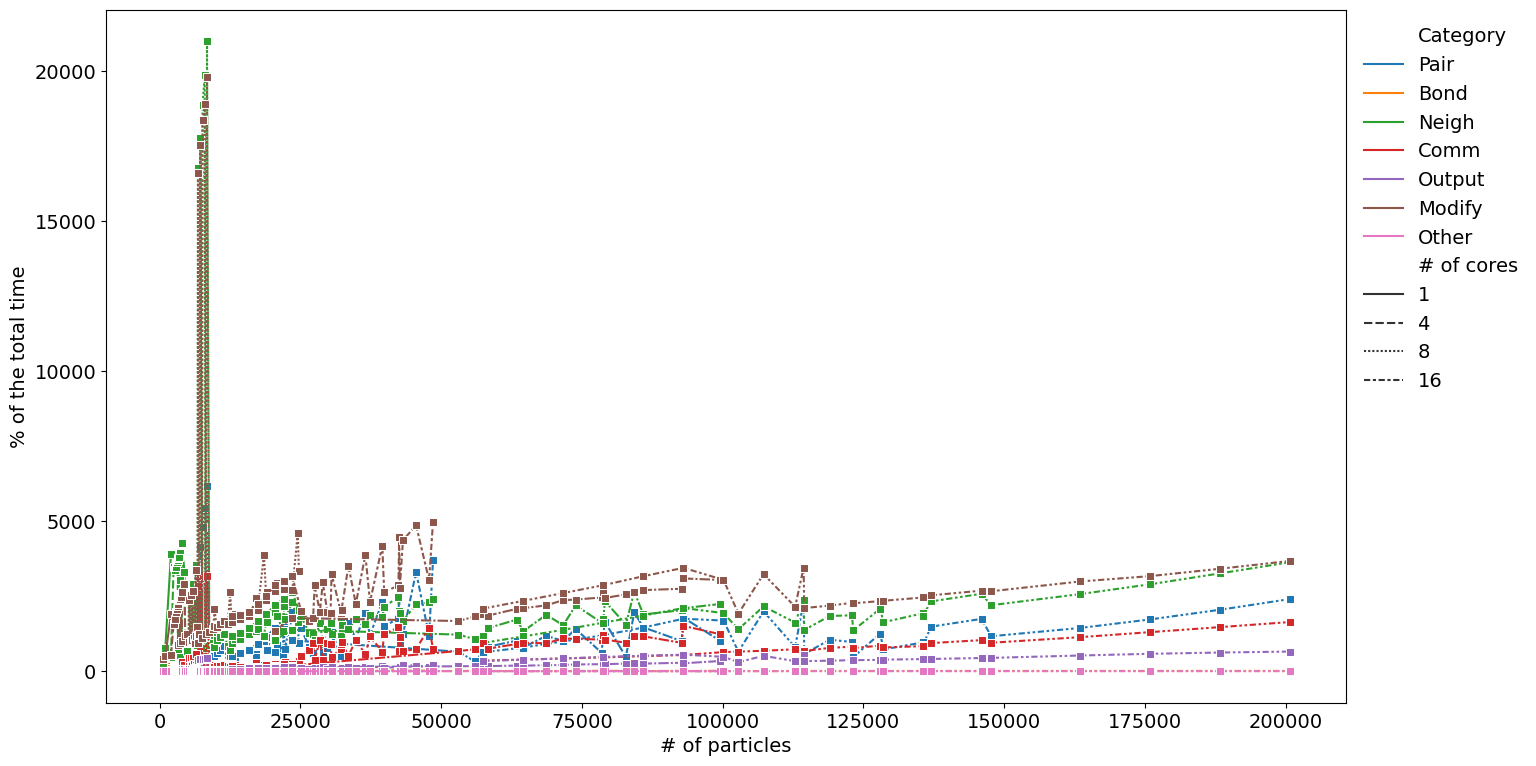

In [72]:
fontsize = 14
save_to = "./"
ext = 'pdf'
new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='pct_of_total_time',
    hue='category',
    style='n_cores',
    marker='s',
    data=run_stats_per_cor_per_atoms_per_cat,
    ax=ax
)
ax_sns.set_xlabel(r"# of particles")
ax_sns.set_ylabel(r"% of the total time")
handles, labels = ax_sns.get_legend_handles_labels()
ax_sns.legend(handles = handles, labels=new_labels, frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["runStat", project]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')

In [76]:
run_stat_prod.columns

Index(['loop_idx', 'loop_time', 'n_cores', 'loop_timesteps', 'n_atoms',
       'tau_day', 'timestep_sec', 'cpu_use', 'mpi_task', 'openmp_threads',
       'Pair_avg_time', 'Pair_total_pct', 'Bond_avg_time', 'Bond_total_pct',
       'Neigh_avg_time', 'Neigh_total_pct', 'Comm_avg_time', 'Comm_total_pct',
       'Output_avg_time', 'Output_total_pct', 'Modify_avg_time',
       'Modify_total_pct', 'Other_avg_time', 'Other_total_pct',
       'dangerous_builds', 'lineage_name', 'whole', 'ensemble_long',
       'ensemble', 'space', 'segment'],
      dtype='object')

In [79]:
sel_cols = [ 'n_cores', 'n_atoms','timestep_sec','dangerous_builds']
agg_funcs = {}
agg_funcs['timestep_sec'] = np.mean
agg_funcs['dangerous_builds'] = np.sum

In [80]:
step_per_sec_stats = run_stat_prod.groupby(['n_cores','n_atoms'])[sel_cols].agg(agg_funcs)
step_per_sec_stats.reset_index(inplace=True)

In [81]:
step_per_sec_stats['timestep_sec_core'] = \
    step_per_sec_stats['timestep_sec'] / step_per_sec_stats['n_cores']

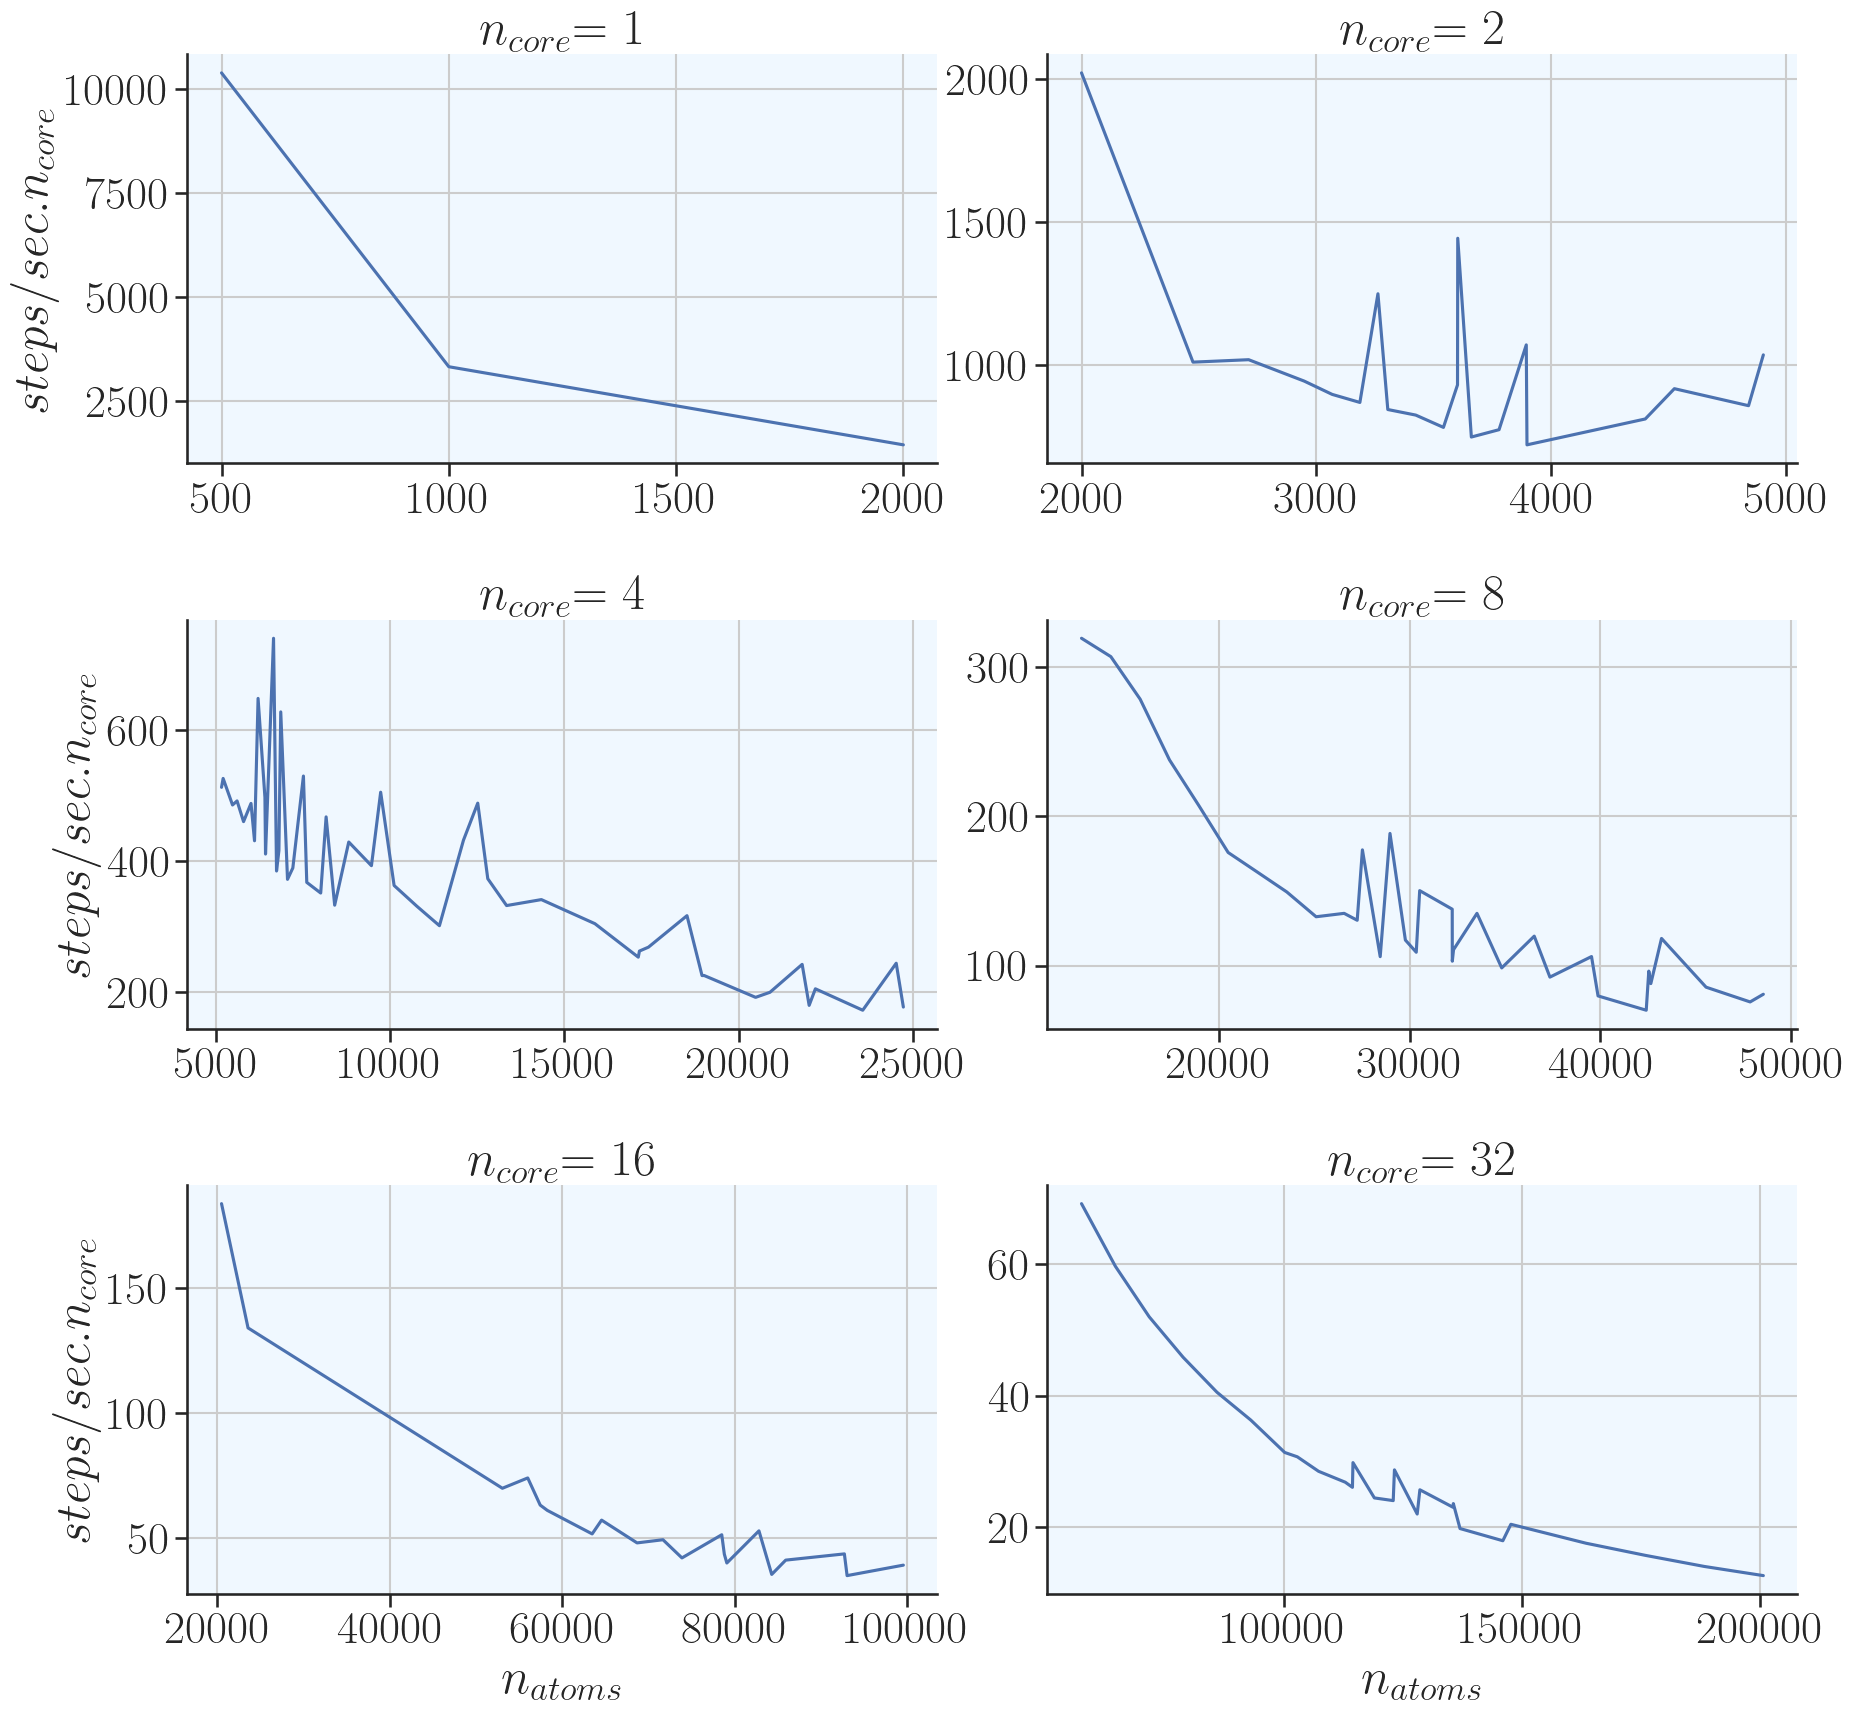

In [87]:
fontsize = 14
save_to = "./"
ext = 'pdf'
new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 6
aspect = 1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True,        
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}

sns.set_theme(
    context=plot_context,
    style='ticks',
  #  palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
stat_grid = sns.relplot(
    x='n_atoms',
    y='timestep_sec_core',
    col='n_cores',
    col_wrap=2,
  #  marker='s',
    data=step_per_sec_stats,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    facet_kws=facet_kws,
)
col_attr = 'n_cores'
attr_labels = {
    'n_cores': r"$n_{{core}}$"
}
stat_grid.set_xlabels(r"$n_{atoms}$")
stat_grid.set_ylabels(r"${steps}/{sec.n_{core}}$")
stat_grid.set_titles(attr_labels[col_attr] + r"$={col_name}$")
stat_grid.tight_layout(w_pad=0)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#output = "-".join(["runStat", project_name]) + "." + ext
#fig.savefig(save_to + output, bbox_inches='tight')

### Visualizing wall-time stats

In [ ]:
wall_time_stats.columns

In [ ]:
wall_time_per_whole = wall_time_stats.groupby(['whole'])['ensemble','whole','n_cores', 'n_atoms','wall_time_hr'].agg({'ensemble': 'last','whole':'last','n_cores':'last', 'n_atoms':'last', 'wall_time_hr': np.sum})
wall_time_per_whole.reset_index(inplace=True,drop=True)
wall_time_per_ensemble = wall_time_per_whole.groupby(['ensemble'])['ensemble','n_cores','n_atoms','wall_time_hr'].agg({'ensemble': 'last','n_cores':'last', 'n_atoms':'last', 'wall_time_hr': np.mean})
wall_time_per_ensemble.reset_index(inplace=True,drop=True)
wall_time_per_ensemble

In [ ]:
wall_time_per_ensemble_sorted = wall_time_per_ensemble.sort_values(by=['n_cores','n_atoms'])

In [ ]:
wall_time_per_ensemble_sorted[wall_time_per_ensemble_sorted.n_cores==2]

In [ ]:
wall_time_stats['wall_time_hr'] = 

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
#new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='wall_time_hr',
    style='n_cores',
    hue='n_cores',
    marker='s',
    data=wall_time_stats,
    ax=ax
)

ax_sns.set_xlabel("# of particles")
ax_sns.set_ylabel("Wall time (hours)")
sns.move_legend(ax_sns, title="# of cores", loc= "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["wallTimeStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')
#plt.close()

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
#new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='wall_time_hr',
    style='n_cores',
    hue='n_cores',
    marker='s',
    data=wall_time_stats,
    ax=ax
)

ax_sns.set_xlabel("# of particles")
ax_sns.set_ylabel("Wall time (hours)")
sns.move_legend(ax_sns, title="# of cores", loc= "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["wallTimeStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')
#plt.close()

### Visualizing thermodynamic data

In [ ]:
thermp_freq = 10000
equilibration_total_steps = 1000000
sampling_first_step = equilibration_total_steps + thermp_freq
thermos_equil = thermos.loc[thermos["Step"]>=sampling_first_step,:]
thermos_equil.reset_index(inplace=True, drop=True)

In [ ]:
thermos_equil.columns

In [ ]:
#sel_cols = ['Step', 'TotEng', 'KinEng', 'Temp', 'PotEng', 'E_bond', 'E_angle',
#       'E_dihed', 'E_impro', 'E_vdwl', 'E_coul', 'E_long', 'Press',
#        'whole', 'ensemble_long', 'ensemble', 'space',
#        'dcyl', 'dmon_large', 'nmon_large',
#        'nmon_small', 'dcrowd', 'dt', 'bdump',
#       'adump', 'ensemble_id',  'phi_c_bulk'] # multi
sel_cols = ['Step', 'Temp', 'E_pair', 'E_mol', 'TotEng', 'Press', 'lineage_name',
       'whole', 'ensemble_long', 'ensemble', 'space', 'nmon', 'epsilon',
       'dcyl', 'lcyl', 'dcrowd', 'ncrowd', 'dt', 'bdump', 'adump',
       'ensemble_id', 'phi_m_bulk', 'rho_m_bulk', 'phi_c_bulk', 'rho_c_bulk'] # one
thermos_equil = thermos_equil.loc[:,sel_cols]

In [ ]:
round_to = 0.025
phi_crds = thermos_equil.loc[:,'phi_c_bulk'].drop_duplicates().sort_values().values
phi_crds = np.round(np.round(phi_crds/round_to) * round_to, 3)
phi_crds = np.unique(phi_crds)
phi_crds.sort()
print(phi_crds)
print("Number of unique phi_c_bulk:", len(phi_crds))
rounding_func = lambda x, round_to: np.round(np.rint((x / round_to)) * round_to, 3)
thermos_equil['phi_c_bulk_round'] = thermos_equil['phi_c_bulk'].apply(
    rounding_func, args=[round_to]
)

In [ ]:
sns.relplot(
    x="Step",
    y="E_bond",
    col='phi_c_bulk_round',
    col_wrap=3,
    hue='ensemble_id',
    ci=None,
    alpha=0.5,
    legend="full",
    kind="line",
    facet_kws={"sharey": False},
    data=thermos_equil
)

In [ ]:
sns.relplot(
    x="Step",
    y="Press",
    col='phi_c_bulk_round',
    col_wrap=3,
    hue='ensemble_id',
    ci=None,
    alpha=0.5,
    legend="full",
    kind="line",
    facet_kws={"sharey": False},
    data=thermos_equil
)

## Not finished: 

In [ ]:
colors = ['royalblue', 'firebrick']
lineage = 'whole'
geometry = 'biaxial'

if len(thermos) % 2 == 0:
    n_cols = len(thermos)//2
else:
    n_cols = len(thermos)//2 + 1
plt.rcParams.update({
    "text.usetex": True, 
})
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['mathtext.default'] = "regular"
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, n_cols, sharex=False, figsize=(9,12))
xdata ='step'
ydata= 'press'
thermp_freq = 10000
equilibration_steps = 1000000
sampling_first_step = equilibration_steps + thermp_freq
sampling_first_row = sampling_first_step // thermp_freq
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    data_info = TransFoci(
            data_path,
            geometry=geometry,
            group='bug',
            lineage=lineage
        )
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True, drop=True)
    #data = data.iloc[sampling_first_row:,:]
    y_mean = data.loc[sampling_first_row:,ydata].mean()
    ax.set_title(fr"$\phi_c^{{bulk}}={np.round(data_info.phi_c_bulk,3)}$")
    ax.axhline(
        y=y_mean, alpha=0.8, ls='--',
        c=color, 
        label=fr"$\bar{{P}}={np.round(y_mean,3)}$"
        )
    ax.plot(
        data.loc[sampling_first_row:,xdata],
        data.loc[sampling_first_row:,ydata], color=color, alpha=0.7,
            label=r"$P(t)$"
    )    
    ax.set_ylabel(r"Pressure, $P(t)$")
    #ax.set_xlabel(r"Time, ${t}/{\Delta t}$")
    ax.set_xlabel(r"Time Step")
    ax.legend()
fname = ydata+"-time-"+data_info.space+"."+'pdf'
fig.tight_layout()
plt.savefig(fname, bbox_inches='tight')
#plt.close()

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    #transition_time = 5500
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True)
    #Use of the following options:
    #data = gyr_t[:transition_time] # before transition at t~5500
    data = data['eVdwl'].to_numpy() # after transition at t~5500
    data = data[101:]
    #data = gyr_t # whole date
    result = analyzer.error_calc_block(data, './block_analysis') 
    #ax.plot(result['si'])
    ax.grid(True, which="both")
    ax.errorbar(result['ntransfroms'], result['si'], yerr=result['si_err'], fmt='--o')
    ax.set_xlabel(r"Number of transformation, $n_{block}$")
    ax.set_ylabel(r"Statistical inefficiency, $s(n_{block})$")

In [ ]:
colors = ['royalblue', 'firebrick']
lineage = 'whole'
geometry = 'biaxial'

if len(thermos) % 2 == 0:
    n_cols = len(thermos)//2
else:
    n_cols = len(thermos)//2 + 1
plt.rcParams.update({
    "text.usetex": True, 
})
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['mathtext.default'] = "regular"
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, n_cols, sharex=False, figsize=(9,12))
xdata ='step'
ydata= 'press'
thermp_freq = 10000
equilibration_steps = 1000000
sampling_first_step = equilibration_steps + thermp_freq
sampling_first_row = sampling_first_step // thermp_freq
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    data_info = TransFoci(
            data_path,
            geometry=geometry,
            group='bug',
            lineage=lineage
        )
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True, drop=True)
    #data = data.iloc[sampling_first_row:,:]
    y_mean = data.loc[sampling_first_row:,ydata].mean()
    ax.set_title(fr"$\phi_c^{{bulk}}={np.round(data_info.phi_c_bulk,3)}$")
    correlations(data.loc[sampling_first_row:,ydata], lags=40)
    ax.set_ylabel(r"Pressure, $P(t)$")
    #ax.set_xlabel(r"Time, ${t}/{\Delta t}$")
    ax.set_xlabel(r"Time Step")
    ax.legend()
fname = ydata+"-time-"+data_info.space+"."+'pdf'
fig.tight_layout()
plt.savefig(fname, bbox_inches='tight')
#plt.close()